In [2]:
%matplotlib inline
import numpy as n
import matplotlib.pyplot as p
import numpy.fft as fft
import scipy.signal as signal
import cosmology as cosmo

0.048252


In [3]:
def readCSTFile(fname):
    traces=[]
    titles=[]
    ntraces=0
    f=open(fname)
    lines=f.readlines()
    nline=len(lines)
    for lnum,line in enumerate(lines):
        entry=line.split()
        if '/' in line or lnum==nline-1:
            if(len(entry)>=1):
                titles.append(entry[-2]+entry[-1])
                #titles.append(entry[-2])

            if(ntraces>0):
                traces.append(n.array(data))
                if(n.mod(len(traces[-1]),2)==1):
                    #traces[-1]=traces[-1][:-1]
                    dt=traces[-1][1,0]-traces[-1][0,0]
                    traces[-1][:,0]+=dt
                    traces[-1]=n.vstack([n.zeros((1,2)),traces[-1]])
            data=[]
            ntraces+=1
        elif(len(entry)==2):
            data.append([float(entry[0]),float(entry[1])])
    f.close()
    return traces,titles

def readVNA(fname,flow=100.,fhigh=200.):
    data=n.loadtxt(fname,skiprows=9,delimiter=',')
    nf=len(data)
    fAxis=n.arange(nf)*(fhigh-flow)/nf+flow
    return fAxis,data[:,0]+1j*data[:,1]


In [38]:
traceListFeedAndDishCylinderBackPlane=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_v2_timetrace.txt')
traceListFeedAndDishBackPlane=readCSTFile('../data/timetraces/paper_dipole_backplane_v2_timetrace.txt')
traceListFeedAndDishBareDipole=readCSTFile('../data/timetraces/paper_dipole_bareDipole_v2_timetrace.txt')
traceListFeedAndDishCylinderBackPlaneAdaptive=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_v2_adaptive_timetrace.txt')
traceListFeedAndDishBackPlaneAdaptive=readCSTFile('../data/timetraces/paper_dipole_backplane_v2_adaptive_timetrace.txt')


traceListPicketFeedOverDish=readCSTFile('../data/timetraces/picket_feed_overDish_terminal_excitation.txt')

traceListFeedAndDishNoGap=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_noGap_v2_timetrace.txt')
traceListFeedAndDishPaneledDipole=readCSTFile('../data/timetraces/paper_dipole_paneled_feed_timetrace.txt')

traceListFeedOnlyCylinderBackPlane=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_feedOnly_v2_timetrace.txt')
traceListFeedOnlyBackPlane=readCSTFile('../data/timetraces/paper_dipole_backplane_feedOnly_v2_timetrace.txt')
traceListFeedOnlyBareDipole=readCSTFile('../data/timetraces/paper_dipole_bareDipole_feedOnly_v2_timetrace.txt')
traceListFeedOnlyPaneledDipole=readCSTFile('../data/timetraces/paper_dipole_paneled_feed_feedOnly_timetrace.txt')


traceListFeedAndDishCylinderBackPlaneHighFreq=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_highFreq_timetrace.txt')
traceListFeedOnlyCylinderBackPlaneHighFreq=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_highFreq_feedOnly_timetrace.txt')

traceListFeedAndDishShortNoGap=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_short_noGap_v2_timetrace.txt')
traceListFeedAndDishShortNoGap=readCSTFile('../data/timetraces/long_time.txt')
traceListFeedOnlyShortNoGap=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_short_noGap_feedOnly_v2_timetrace.txt')



traceListFeedAndDishShortGap=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_short_Gap_v2_timetrace.txt')
traceListFeedOnlyShortGap=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_short_gap_feedOnly_v2_timetrace.txt')



traceListFeedAndDishNoGap=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_noGap_v2_timetrace.txt')
traceListFeedOnlyNoGap=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_noGap_feedOnly_v2_timetrace.txt')


traceListCTPFeedAndDish=readCSTFile('../data/timetraces/CTP_feedOverDish_timetrace.txt')
traceListCTPFeedOnly=readCSTFile('../data/timetraces/CTP_feedOnly_timetrace.txt')




traceListCTPShortNoGapFeedAndDish=readCSTFile('../data/timetraces/CTP_short_noGap_feedOverDish_timetrace.txt')
traceListCTPShortNoGapFeedOnly=readCSTFile('../data/timetraces/CTP_short_noGap_feedOnly_timetrace.txt')


traceListCTPShortGapFeedAndDish=readCSTFile('../data/timetraces/CTP_short_feedOverDish_timetrace.txt')
traceListCTPShortGapFeedOnly=readCSTFile('../data/timetraces/CTP_short_feedOnly_timetrace.txt')


traceListHighFreq=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_highFreq_timetrace.txt')
traceListHighFreq_SA=readCSTFile('/Users/aaronew/Dropbox (MIT)/Science/AntennaDataHERA/cst/SouthAfricaFeedOverDish/SouthAfricaFeedOverDish_noGap_planeWave.txt')


#traceListFeedAndDishCylinderBackPlaneV2=readCSTFile('../data/timetraces/paper_dipole_cylinder_backplane_v2_timetrace.txt')
#traceListFeedAndDishBackPlaneV2=readCSTFile('../data/timetraces/paper_dipole_backplane_v2_timetrace.txt')

In [5]:

def plotTraces(traceList,flow,fhigh,titleList=['o1','Planewave'],ls='-',lastPlot=True,translate=0.,labels=[],colors=['k'],xlims=[-300,300],ylims=[-70,0],nLegendCols=1,legend=False):
    lines=[]
    nt=len(traceList[0])
    dt=traceList[0][1,0]-traceList[0][0,0]
    print nt
    print dt
    iInd=0
    oInd=0
    #determine whether plane wave or i1    
    while('Planewave' not in titleList[iInd] and 'i1' not in titleList[iInd]):
        iInd+=1
    while('o1' not in titleList[oInd]):
        oInd+=1
    
    for mm in range(len(flow)):
        pwPadTimeSimulation=n.pad(traceList[iInd][:,1],(int(nt*.5),int(nt*.5)),mode='constant')
        vrPadTimeSimulation=n.pad(traceList[oInd][:,1],(int(nt*.5),int(nt*.5)),mode='constant')
        fAxisPadTimeSimulation=(fft.fftfreq(len(vrPadTimeSimulation),dt))
        fWaveTimeSimulation=fft.fft(fft.fftshift(pwPadTimeSimulation))
        fResponseTimeSimulation=fft.fft(fft.fftshift(vrPadTimeSimulation))
        dfTimeSimulation=fAxisPadTimeSimulation[1]-fAxisPadTimeSimulation[0]

        selectionPos=n.logical_and(fAxisPadTimeSimulation>=flow[mm]/1e3,fAxisPadTimeSimulation<=fhigh[mm]/1e3)
        selectionNeg=n.logical_and(-fAxisPadTimeSimulation>=flow[mm]/1e3,-fAxisPadTimeSimulation<=fhigh[mm]/1e3)
        nSelect=len(fAxisPadTimeSimulation[selectionPos])
        if(n.mod(nSelect,2)==1):
            nmaxPos=n.where(fAxisPadTimeSimulation[selectionPos].max()==fAxisPadTimeSimulation)[0][0]
            nmaxNeg=n.where(fAxisPadTimeSimulation[selectionNeg].min()==fAxisPadTimeSimulation)[0][0]
            selectionPos[nmaxPos+1]=True
            selectionNeg[nmaxNeg-1]=True
            nSelect+=1
        #windowTimeSimulation=n.hamming(nSelect)
        windowTimeSimulation=signal.blackmanharris(nSelect)
        #windowTimeSimulation=signal.blackmanharris(nSelect/2)
        #windowTimeSimulation=signal.fftconvolve(windowTimeSimulation,windowTimeSimulation[::-1],mode='full')
        #windowTimeSimulation=n.append(windowTimeSimulation,0)
        windowTimeSimulation=windowTimeSimulation/windowTimeSimulation.mean()
        windowTimeSimulationFull=n.zeros(2*nt)
        windowTimeSimulationFull[selectionPos]=windowTimeSimulation
        windowTimeSimulationFull[selectionNeg]=windowTimeSimulation
        delayResponseTimeSimulation=fft.fftshift(fft.ifft(fft.fftshift((windowTimeSimulationFull*fResponseTimeSimulation/fWaveTimeSimulation)[selectionPos])))
        tAxisTimeSimulation=fft.fftshift(fft.fftfreq(len(delayResponseTimeSimulation),dfTimeSimulation))

    #use kparallel
        littleh=.68
        kParaTimeSimulation=cosmo.eta2kpara(tAxisTimeSimulation/1e9-35e-9,cosmo.f2z((fhigh[mm]-flow[mm])/2.*1e6+flow[0]*1e6))/littleh
        #kParaMeasured=cosmo.eta2kpara(tAxisMeasured/1e9,cosmo.f2z((fhigh[mm]-flow[mm])/2.*1e6+flow[0]*1e6))/littleh

        responseSimulatedKernel=signal.fftconvolve(delayResponseTimeSimulation,n.conj(delayResponseTimeSimulation)[::-1],mode='same')
        try:
            label=labels[mm]
        except:
            label='%d-%d MHz'%(flow[mm],fhigh[mm])
        try:
            color=colors[mm]
        except:
            color='k'
        #p.plot(tAxisTimeSimulation,10.*n.log10(n.abs(responseSimulatedKernel)/n.abs(responseSimulatedKernel).max()),'-o',label='Simulation, Zenith',markersize=4,lw=2)
        if(fhigh[mm]-flow[mm]>50):
            lw=4
            lines.append(p.plot(tAxisTimeSimulation-translate,10.*n.log10(n.abs(delayResponseTimeSimulation)/n.abs(delayResponseTimeSimulation).max()),'-o',color=color,label=label,markersize=4,lw=lw,ls=ls)[0])

        else:
            lw=2
            lines.append(p.plot(tAxisTimeSimulation-translate,10.*n.log10(n.abs(delayResponseTimeSimulation)/n.abs(delayResponseTimeSimulation).max()),'-o',label=label,markersize=4,lw=lw,ls=ls)[0])

    if(lastPlot):
        #p.gca().set_xticks(n.arange(-140,500,30))
        p.gca().tick_params('x',labelsize=22)
        p.gca().tick_params('y',labelsize=22)
        p.grid()
        if(legend):
            p.legend(loc='best',fontsize=18,ncol=nLegendCols)
        p.xlim(xlims)
        p.ylim(ylims)
        ax1=p.gca()
        ax2=p.gca().twiny()
        ax2.set_xticks(ax1.get_xticks())
        ax2.set_xlim(ax1.get_xlim())
        ticklabels=[]
        for tick in ax2.get_xticks():
            ticklabels.append('%.2f'%(cosmo.eta2kpara(tick/1e9,cosmo.f2z(83e6))/littleh))

        ax2.set_xticklabels(ticklabels)
        ax2.tick_params('x',labelsize=22)
        ax2.set_xlabel('$k_{\\parallel}$ ($h$Mpc$^{-1}$)',fontsize=25)
        ax1.set_xlabel('$\\tau$ (ns)',fontsize=25)
        ax1.set_ylabel('Voltage Response (dB)',fontsize=25)
        p.gcf().set_size_inches([14,10])
    return lines


6712
0.11917853


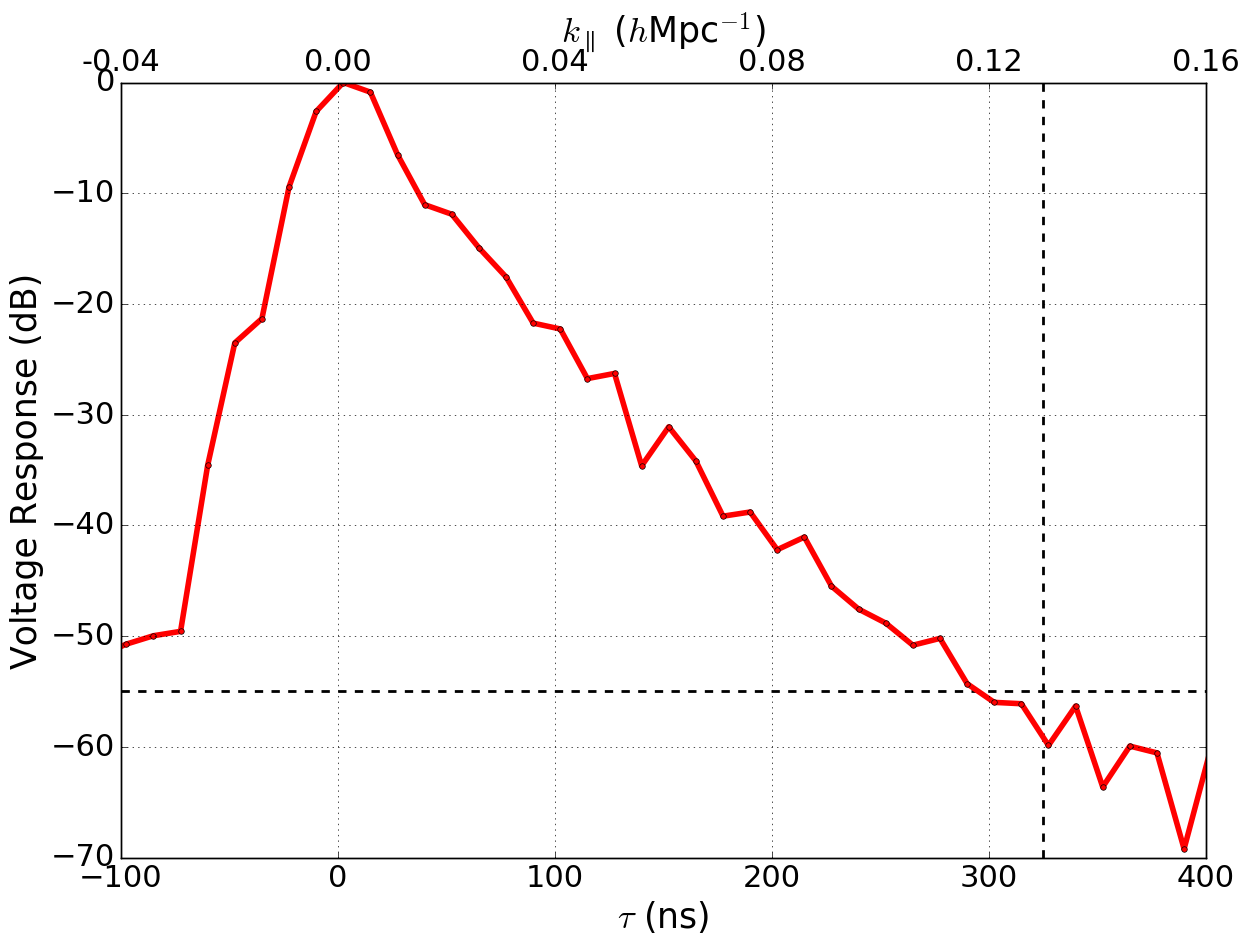

In [5]:
flow=[50]
fhigh=[130]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Low Frequency Feed (50-130MHz)'],xlims=[-30,400])
#flow=[100]
#fhigh=[200]
#plotTraces(traceListHighFreq[0],flow,fhigh,traceListHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency Feed (100-200MHz)'],xlims=[-30,300],colors=['grey'])
p.axvline(325,ls='--',lw=2,color='k')
p.axhline(-55,ls='--',lw=2,color='k')
linesFull=plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=True,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-100,400],colors=['r'])


#plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=True,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-30,400],colors=['r'])



#plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')


#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['r'],xlims=[-100,400])
#plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


#flow=[100]
#fhigh=[180]
#plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
#plotTraces(traceListFeedOnlyCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedOnlyCylinderBackPlaneHighFreq[1],lastPlot=True,translate=0.,labels=['High Frequency\nFeed Only'],colors=['grey'],ls='--',xlims=[-100,300],nLegendCols=3)




#p.savefig('/Users/aaronew/Dropbox/RadioFutures/DelayResponse_heraEoX.pdf')










7920
0.062122446
6720
0.046591833
7392
0.046591833
6970
0.038826529
7200
0.046591833
7906
0.085418366


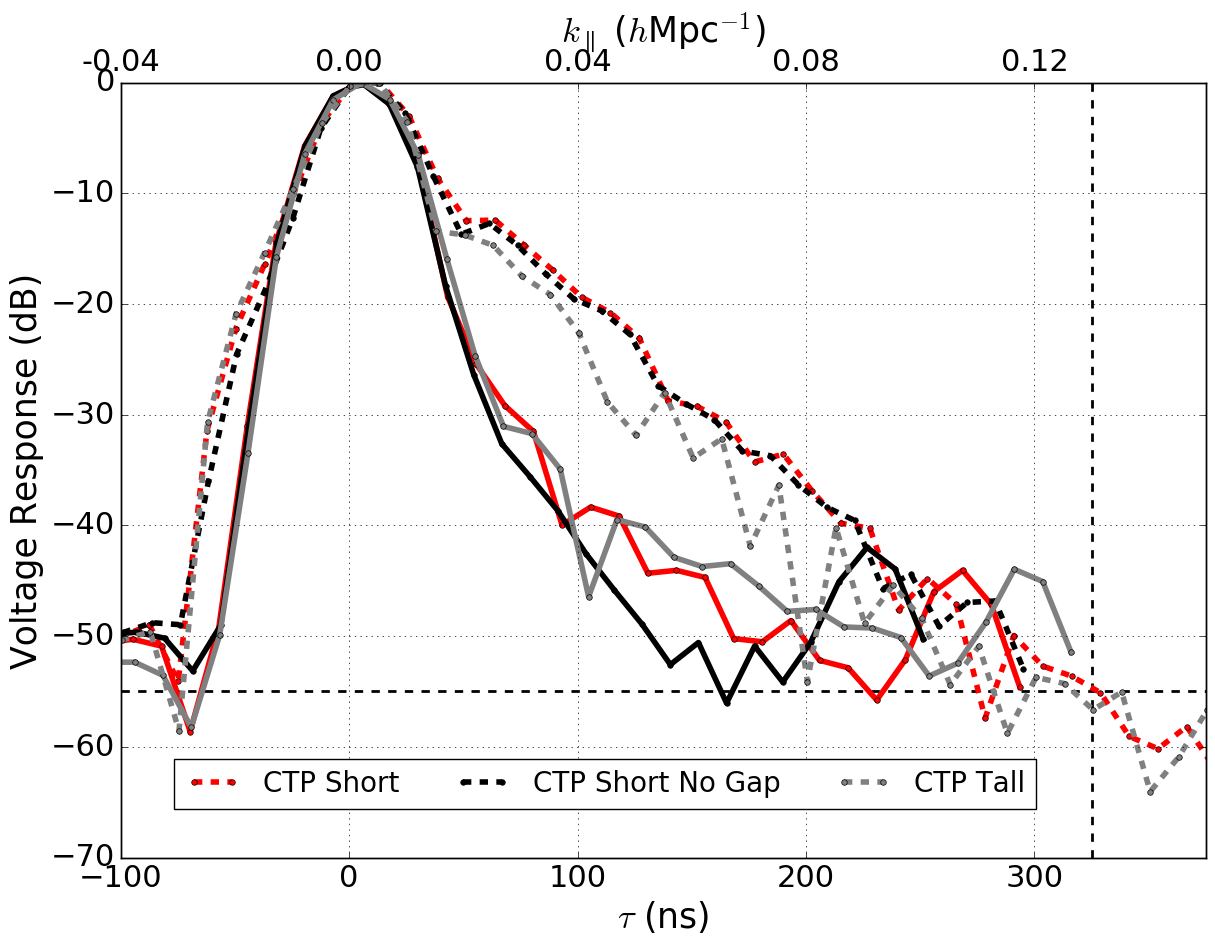

In [41]:
#flow=[100]
#fhigh=[180]
#lh1=plotTraces(traceListHighFreq[0],flow,fhigh,traceListHighFreq[1],lastPlot=False,translate=35.,labels=['Prototype High Frequency'],colors=['orange'],ls='--',xlims=[-100,300])
#lh2=plotTraces(traceListHighFreq_SA[0],flow,fhigh,traceListHighFreq_SA[1],lastPlot=False,translate=35.,labels=['Deployed High Frequency'],colors=['magenta'],ls='--',xlims=[-100,300])
flow=[50]
fhigh=[130]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Low Frequency Feed (50-130MHz)'],xlims=[-30,400])
p.axvline(325,ls='--',lw=2,color='k')
p.axhline(-55,ls='--',lw=2,color='k')
#plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=False,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-100,400],colors=['k'])


#plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=True,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-30,400],colors=['r'])



#plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')

#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300],colors=['grey'])
#plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['red'],xlims=[-100,400])
linesFull=plotTraces(traceListCTPShortGapFeedAndDish[0],flow,fhigh,traceListCTPShortGapFeedAndDish[1],lastPlot=False,translate=37.,labels=['CTP\nFeed Short'],colors=['r'],xlims=[-100,300],ls='--')
plotTraces(traceListCTPShortGapFeedOnly[0],flow,fhigh,traceListCTPShortGapFeedOnly[1],lastPlot=False,translate=7.,labels=['CTP\nFeed Short'],colors=['r'],xlims=[-100,300],ls='-')
linesFull+=plotTraces(traceListCTPShortNoGapFeedAndDish[0],flow,fhigh,traceListCTPShortNoGapFeedAndDish[1],lastPlot=False,translate=37.,labels=['CTP\nFeed Short No Gap'],colors=['k'],xlims=[-100,300],ls='--')
plotTraces(traceListCTPShortNoGapFeedOnly[0],flow,fhigh,traceListCTPShortNoGapFeedOnly[1],lastPlot=False,translate=7.,labels=['CTP\nFeed Short No Gap'],colors=['k'],xlims=[-100,300],ls='-')
plotTraces(traceListCTPFeedOnly[0],flow,fhigh,traceListCTPFeedOnly[1],lastPlot=False,translate=7.,labels=['CTP\nFeed Short No Gap'],colors=['grey'],xlims=[-100,300],ls='-')




#flow=[100]
#fhigh=[180]
#plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
linesFull+=plotTraces(traceListCTPFeedAndDish[0],flow,fhigh,traceListCTPFeedAndDish[1],lastPlot=True,translate=37.,labels=['CTP\nFeed '],colors=['grey'],ls='--',xlims=[-100,375],nLegendCols=3)

#flow=[50]
#fhigh=[130]
#plotTraces(traceListPicketFeedOverDish[0],flow,fhigh,traceListPicketFeedOverDish[1],lastPlot=True,translate=35.,labels=['Picket Feed Terminal'],xlims=[-30,350],colors=['orange'])
p.gcf().legend(linesFull,['CTP Short','CTP Short No Gap','CTP Tall'],ncol=3,loc='best',bbox_to_anchor=(.75,.2),fontsize=20)


p.savefig('../analysis/traceComparison_CTP_Only.pdf',bbox_inches='tight')

7712
0.10938557
7634
0.043767747
7920
0.062122446
7392
0.046591833
7906
0.085418366


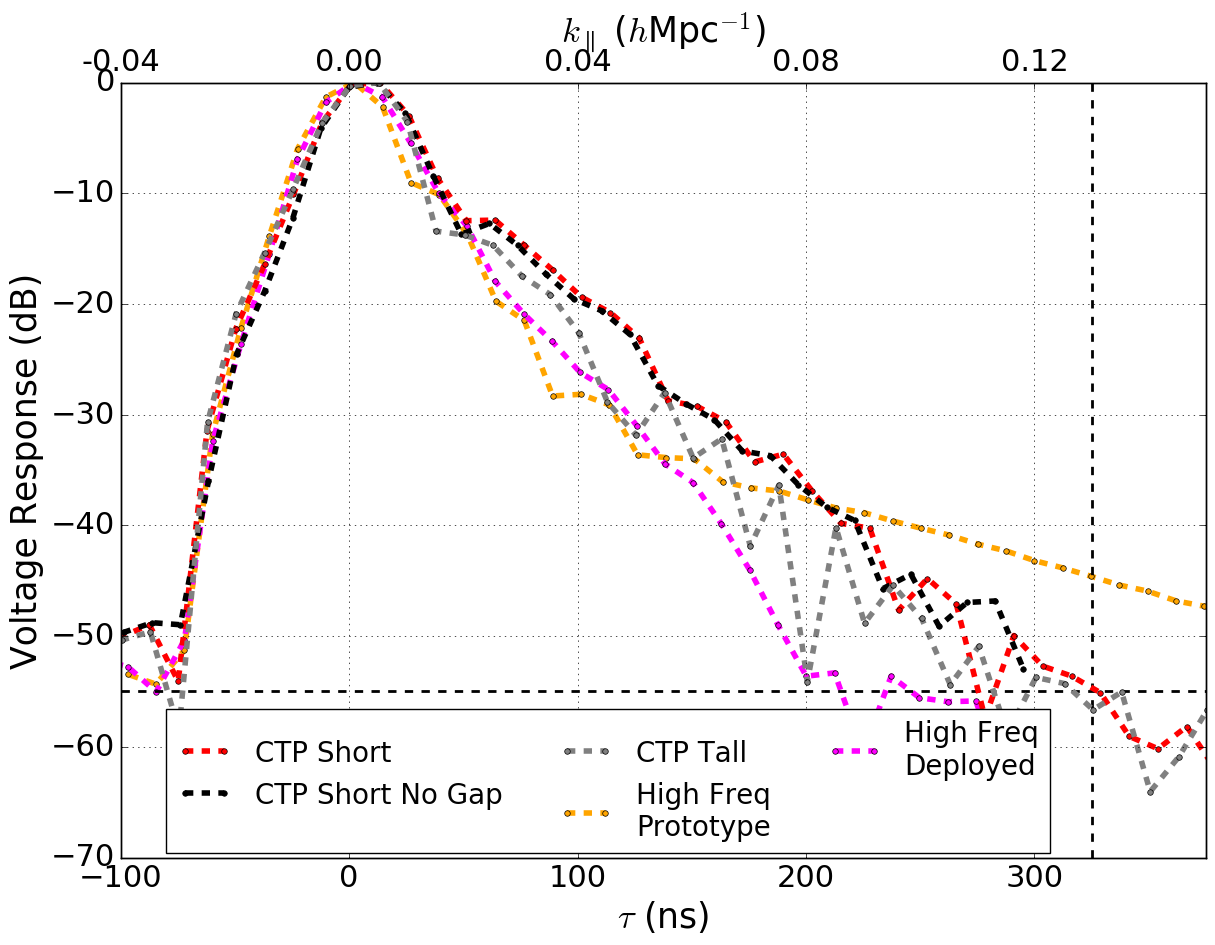

In [49]:
flow=[100]
fhigh=[180]
lh1=plotTraces(traceListHighFreq[0],flow,fhigh,traceListHighFreq[1],lastPlot=False,translate=35.,labels=['Prototype High Frequency'],colors=['orange'],ls='--',xlims=[-100,300])
lh2=plotTraces(traceListHighFreq_SA[0],flow,fhigh,traceListHighFreq_SA[1],lastPlot=False,translate=35.,labels=['Deployed High Frequency'],colors=['magenta'],ls='--',xlims=[-100,300])
flow=[50]
fhigh=[130]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Low Frequency Feed (50-130MHz)'],xlims=[-30,400])
p.axvline(325,ls='--',lw=2,color='k')
p.axhline(-55,ls='--',lw=2,color='k')
#plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=False,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-100,400],colors=['k'])


#plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=True,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-30,400],colors=['r'])



#plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')

#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300],colors=['grey'])
#plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['red'],xlims=[-100,400])
linesFull=plotTraces(traceListCTPShortGapFeedAndDish[0],flow,fhigh,traceListCTPShortGapFeedAndDish[1],lastPlot=False,translate=37.,labels=['CTP\nFeed Short'],colors=['r'],xlims=[-100,300],ls='--')
#plotTraces(traceListCTPShortGapFeedOnly[0],flow,fhigh,traceListCTPShortGapFeedOnly[1],lastPlot=False,translate=7.,labels=['CTP\nFeed Short'],colors=['r'],xlims=[-100,300],ls='-')
linesFull+=plotTraces(traceListCTPShortNoGapFeedAndDish[0],flow,fhigh,traceListCTPShortNoGapFeedAndDish[1],lastPlot=False,translate=37.,labels=['CTP\nFeed Short No Gap'],colors=['k'],xlims=[-100,300],ls='--')
#plotTraces(traceListCTPShortNoGapFeedOnly[0],flow,fhigh,traceListCTPShortNoGapFeedOnly[1],lastPlot=False,translate=7.,labels=['CTP\nFeed Short No Gap'],colors=['k'],xlims=[-100,300],ls='-')
#plotTraces(traceListCTPFeedOnly[0],flow,fhigh,traceListCTPFeedOnly[1],lastPlot=False,translate=7.,labels=['CTP\nFeed Short No Gap'],colors=['grey'],xlims=[-100,300],ls='-')




#flow=[100]
#fhigh=[180]
#plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
linesFull+=plotTraces(traceListCTPFeedAndDish[0],flow,fhigh,traceListCTPFeedAndDish[1],lastPlot=True,translate=37.,labels=['CTP\nFeed '],colors=['grey'],ls='--',xlims=[-100,375],nLegendCols=3)
linesFull+=lh1
linesFull+=lh2
#flow=[50]
#fhigh=[130]
#plotTraces(traceListPicketFeedOverDish[0],flow,fhigh,traceListPicketFeedOverDish[1],lastPlot=True,translate=35.,labels=['Picket Feed Terminal'],xlims=[-30,350],colors=['orange'])
p.gcf().legend(linesFull,['CTP Short','CTP Short No Gap','CTP Tall','High Freq\nPrototype','High Freq\nDeployed'],ncol=3,loc='best',bbox_to_anchor=(.76,.25),fontsize=20)


p.savefig('../analysis/traceComparison_CTP.pdf',bbox_inches='tight')

6712
0.11917853
7698
0.052281339
7726
0.07669872
7906
0.085418366
7882
0.066693231


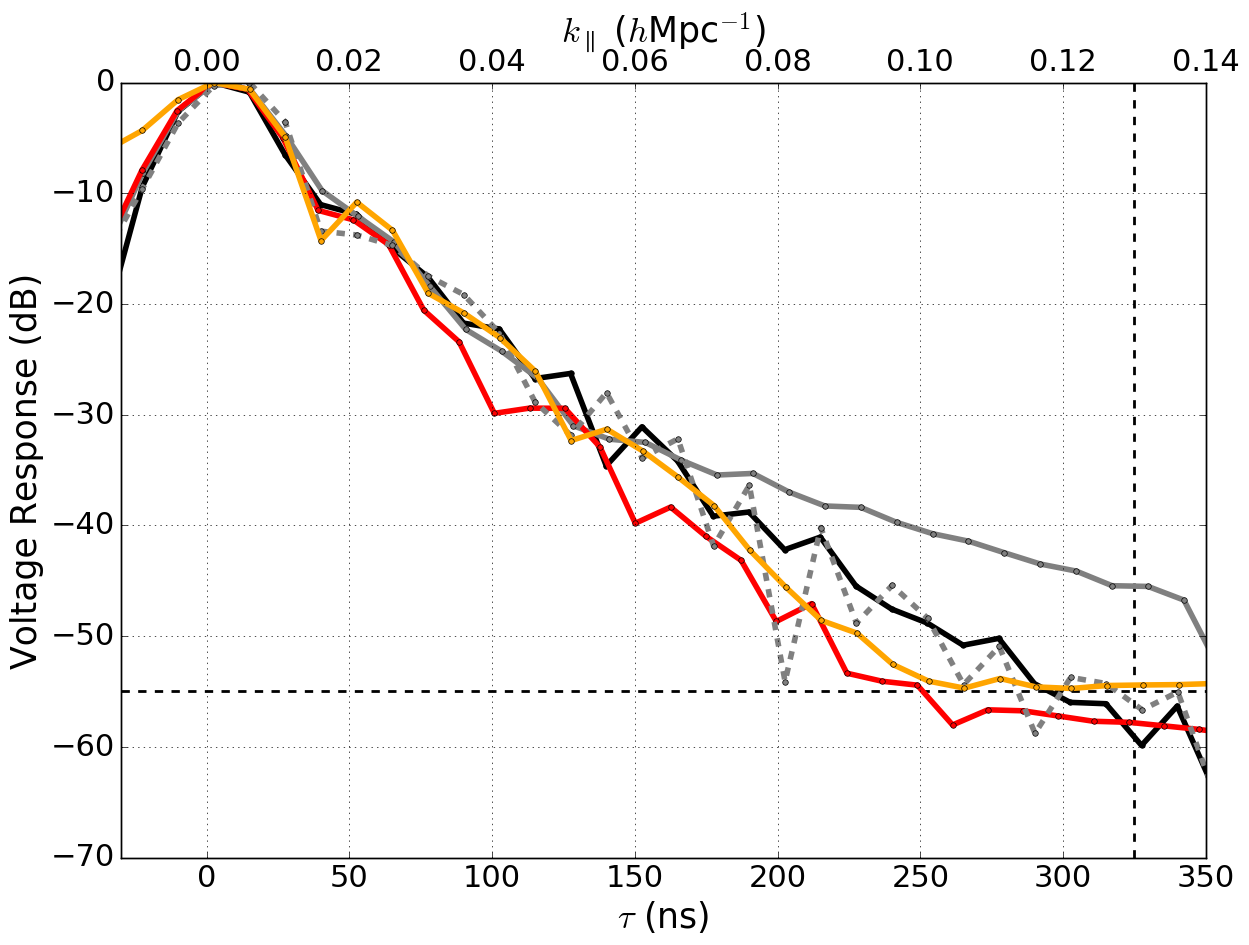

In [6]:
flow=[50]
fhigh=[130]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Low Frequency Feed (50-130MHz)'],xlims=[-30,400])
p.axvline(325,ls='--',lw=2,color='k')
p.axhline(-55,ls='--',lw=2,color='k')
plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=False,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-100,400],colors=['k'])


#plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=True,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-30,400],colors=['r'])



#plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')


#flow=[50]
#fhigh=[150]
plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300],colors=['grey'])
plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['red'],xlims=[-100,400])
#plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


#flow=[100]
#fhigh=[180]
#plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
plotTraces(traceListCTPFeedAndDish[0],flow,fhigh,traceListCTPFeedAndDish[1],lastPlot=False,translate=35.,labels=['CTP\nFeed '],colors=['grey'],ls='--',xlims=[-100,300],nLegendCols=3)

flow=[50]
fhigh=[130]
plotTraces(traceListPicketFeedOverDish[0],flow,fhigh,traceListPicketFeedOverDish[1],lastPlot=True,translate=35.,labels=['Picket Feed Terminal'],xlims=[-30,350],colors=['orange'])




p.savefig('../analysis/traceComparison_CTP.pdf')

6712
0.11917853
7698
0.052281339
7726
0.07669872
7712
0.10938557


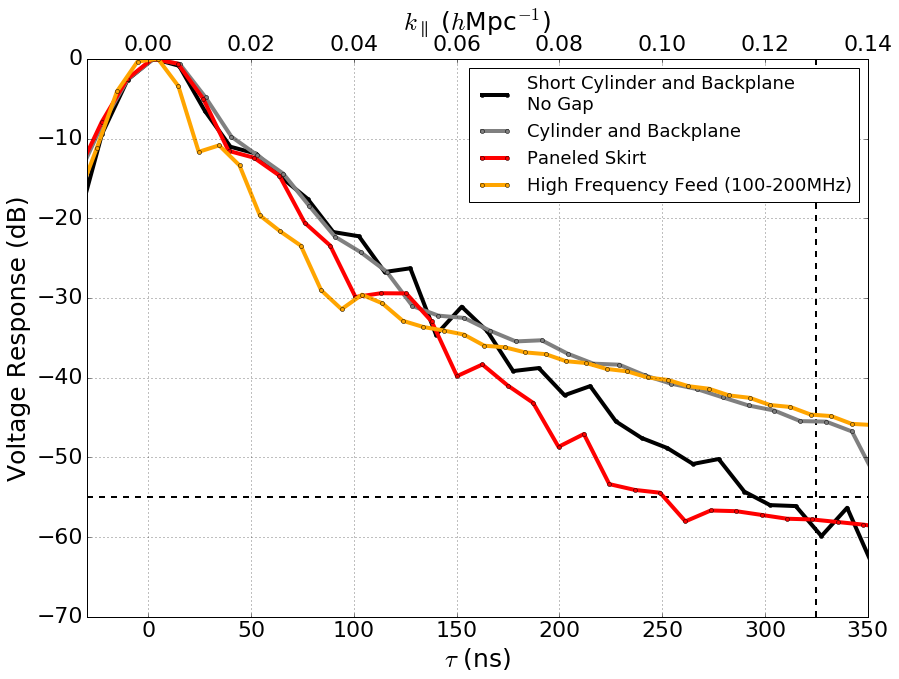

In [14]:
flow=[50]
fhigh=[130]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Low Frequency Feed (50-130MHz)'],xlims=[-30,400])
p.axvline(325,ls='--',lw=2,color='k')
p.axhline(-55,ls='--',lw=2,color='k')
plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=False,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-100,400],colors=['k'])


#plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=True,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-30,400],colors=['r'])



#plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')


#flow=[50]
#fhigh=[150]
plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300],colors=['grey'])
plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['red'],xlims=[-100,400])
#plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


#flow=[100]
#fhigh=[180]
#plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
#plotTraces(traceListFeedOnlyCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedOnlyCylinderBackPlaneHighFreq[1],lastPlot=True,translate=0.,labels=['High Frequency\nFeed Only'],colors=['grey'],ls='--',xlims=[-100,300],nLegendCols=3)

flow=[100]
fhigh=[200]
plotTraces(traceListHighFreq[0],flow,fhigh,traceListHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency Feed (100-200MHz)'],xlims=[-30,350],colors=['orange'])




p.savefig('../analysis/traceComparison.pdf')











6712
0.11917853
5750
0.053915191
7380
0.1280811
7996
0.05475625
7698
0.052281339
6586
0.052031081
7486
0.12001927
6710
0.10247542
7726
0.07669872
7868
0.06002463


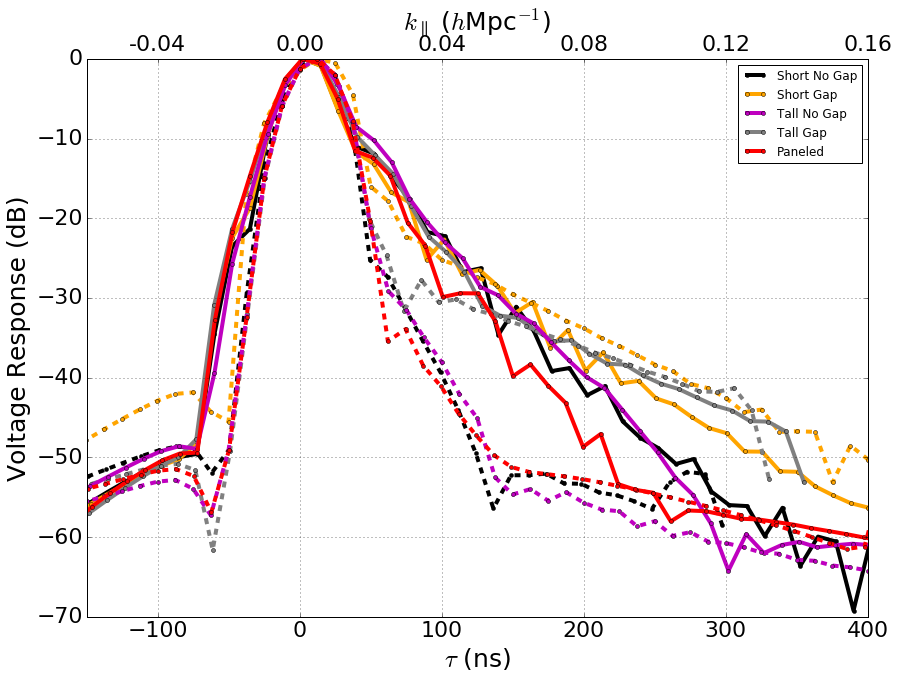

In [42]:
flow=[50]
fhigh=[130]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Low Frequency Feed (50-130MHz)'],xlims=[-30,400])
#p.axvline(325,ls='--',lw=2,color='k')
#p.axhline(-55,ls='--',lw=2,color='k')
l0=plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=False,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-100,400],colors=['k'])[0]
plotTraces(traceListFeedOnlyShortNoGap[0],flow,fhigh,traceListFeedOnlyShortNoGap[1],lastPlot=False,translate=0.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-100,400],colors=['k'],ls='--')

l1=plotTraces(traceListFeedAndDishShortGap[0],flow,fhigh,traceListFeedAndDishShortGap[1],lastPlot=False,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-100,400],colors=['orange'])[0]
plotTraces(traceListFeedOnlyShortGap[0],flow,fhigh,traceListFeedOnlyShortGap[1],lastPlot=False,translate=0.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-100,400],colors=['orange'],ls='--')



l3=plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300],colors=['grey'])[0]
plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],colors=['grey'],ls='--')

l2=plotTraces(traceListFeedAndDishNoGap[0],flow,fhigh,traceListFeedAndDishNoGap[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300],colors=['m'])[0]
plotTraces(traceListFeedOnlyNoGap[0],flow,fhigh,traceListFeedAndDishNoGap[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],colors=['m'],ls='--')




l4=plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['red'],xlims=[-100,400])[0]
plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=True,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['red'],xlims=[-150,400],ls='--')


p.gca().legend((l0,l1,l2,l3,l4),('Short No Gap','Short Gap','Tall No Gap','Tall Gap','Paneled'),loc='best')


p.savefig('../analysis/traceComparisonFeedsVDishes.pdf')












6712
0.11917853


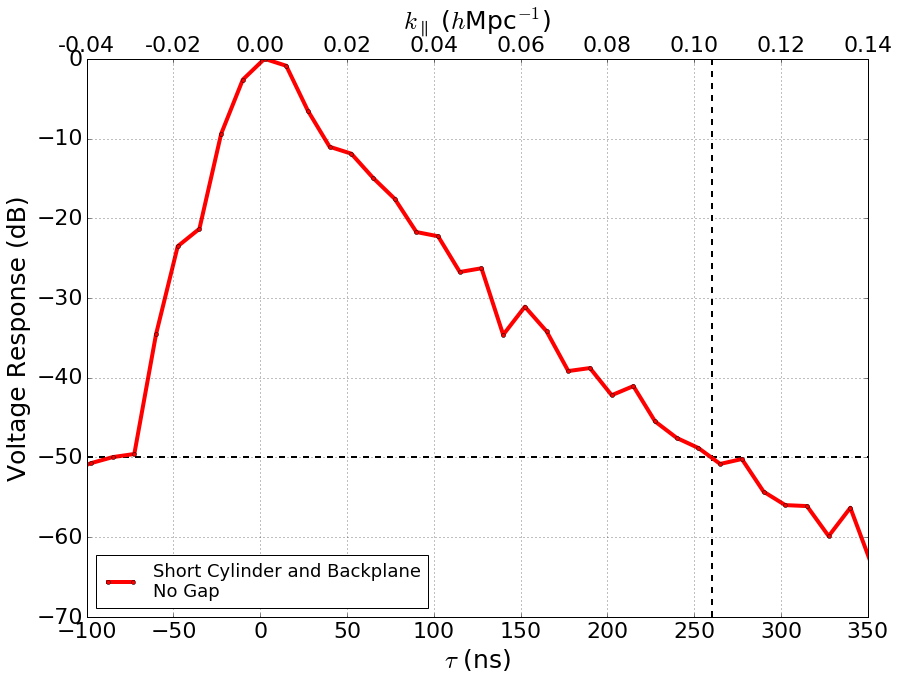

In [7]:
flow=[50]
fhigh=[130]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Low Frequency Feed (50-130MHz)'],xlims=[-30,400])
#flow=[100]
#fhigh=[200]
#plotTraces(traceListHighFreq[0],flow,fhigh,traceListHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency Feed (100-200MHz)'],xlims=[-30,300],colors=['grey'])
p.axvline(260,ls='--',lw=2,color='k')
p.axhline(-50,ls='--',lw=2,color='k')
plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=True,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-100,350],colors=['r'])


#plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=True,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-30,400],colors=['r'])



#plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')


#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['r'],xlims=[-100,400])
#plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


#flow=[100]
#fhigh=[180]
#plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
#plotTraces(traceListFeedOnlyCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedOnlyCylinderBackPlaneHighFreq[1],lastPlot=True,translate=0.,labels=['High Frequency\nFeed Only'],colors=['grey'],ls='--',xlims=[-100,300],nLegendCols=3)




#p.savefig('/Users/aaronew/Dropbox/RadioFutures/DelayResponse_heraEoX.pdf')










7698
0.052281339
7486
0.12001927
6712
0.11917853
7726
0.07669872


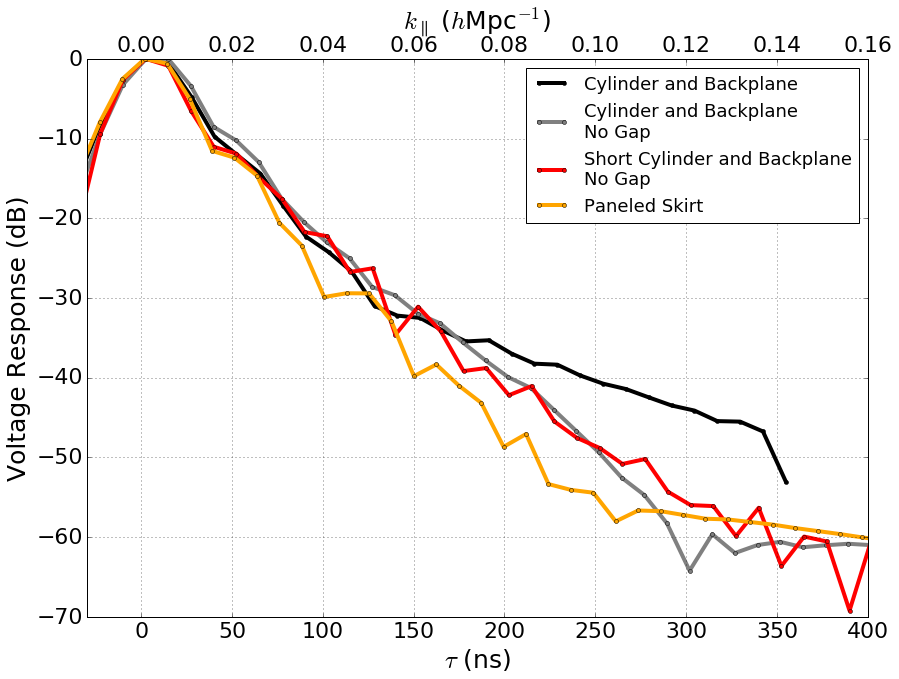

In [8]:
flow=[50]
fhigh=[130]
plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,400])
plotTraces(traceListFeedAndDishNoGap[0],flow,fhigh,traceListFeedAndDishNoGap[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane\nNo Gap'],xlims=[-30,300],colors=['grey'])
plotTraces(traceListFeedAndDishShortNoGap[0],flow,fhigh,traceListFeedAndDishShortNoGap[1],lastPlot=False,translate=35.,labels=['Short Cylinder and Backplane\nNo Gap'],xlims=[-30,400],colors=['r'])
plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=True,translate=35.,labels=['Paneled Skirt'],colors=['orange'],xlims=[-30,400])



#plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')


#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['r'],xlims=[-100,400])
#plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


#flow=[100]
#fhigh=[180]
#plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
#plotTraces(traceListFeedOnlyCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedOnlyCylinderBackPlaneHighFreq[1],lastPlot=True,translate=0.,labels=['High Frequency\nFeed Only'],colors=['grey'],ls='--',xlims=[-100,300],nLegendCols=3)




p.savefig('../analysis/compare_Traces_NoGap.pdf')









7698
0.052281339
6940
0.087134063


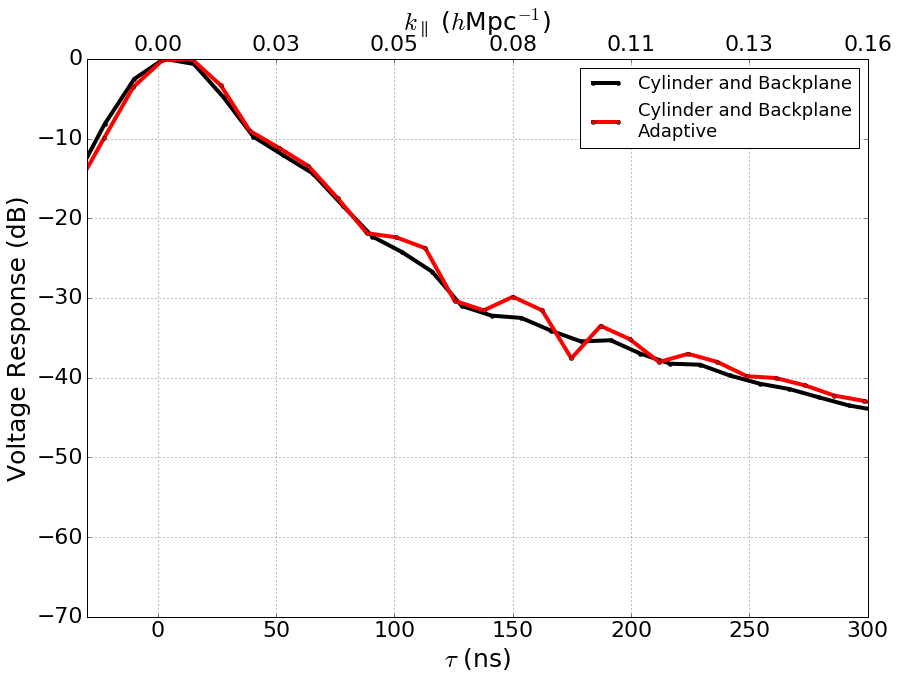

In [8]:
flow=[50]
fhigh=[130]
plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
plotTraces(traceListFeedAndDishCylinderBackPlaneAdaptive[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneAdaptive[1],lastPlot=True,translate=35.,labels=['Cylinder and Backplane\nAdaptive'],xlims=[-30,300],colors=['r'])


#plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')


#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['r'],xlims=[-100,400])
#plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


#flow=[100]
#fhigh=[180]
#plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
#plotTraces(traceListFeedOnlyCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedOnlyCylinderBackPlaneHighFreq[1],lastPlot=True,translate=0.,labels=['High Frequency\nFeed Only'],colors=['grey'],ls='--',xlims=[-100,300],nLegendCols=3)




p.savefig('../analysis/compare_Traces_Adaptive.pdf')








6688
0.049551547
7860
0.12722234


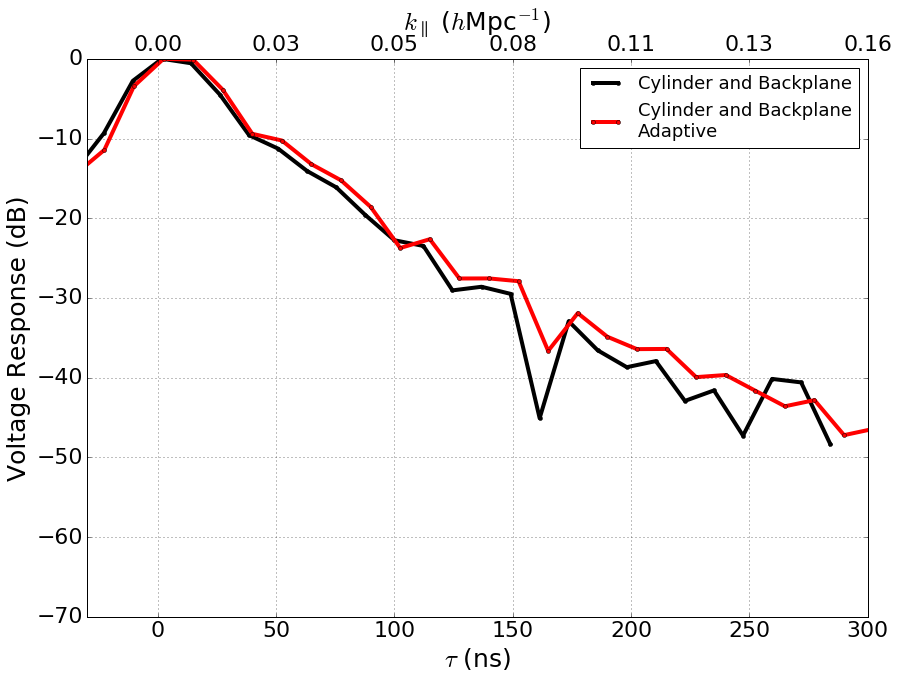

In [6]:
flow=[50]
fhigh=[130]
plotTraces(traceListFeedAndDishBackPlane[0],flow,fhigh,traceListFeedAndDishBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
plotTraces(traceListFeedAndDishBackPlaneAdaptive[0],flow,fhigh,traceListFeedAndDishBackPlaneAdaptive[1],lastPlot=True,translate=35.,labels=['Cylinder and Backplane\nAdaptive'],xlims=[-30,300],colors=['r'])


#plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')


#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['r'],xlims=[-100,400])
#plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


#flow=[100]
#fhigh=[180]
#plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
#plotTraces(traceListFeedOnlyCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedOnlyCylinderBackPlaneHighFreq[1],lastPlot=True,translate=0.,labels=['High Frequency\nFeed Only'],colors=['grey'],ls='--',xlims=[-100,300],nLegendCols=3)




p.savefig('../analysis/compare_Traces_Adaptive_BackPlane.pdf')









7698
0.052281339
7726
0.07669872
7712
0.10938557


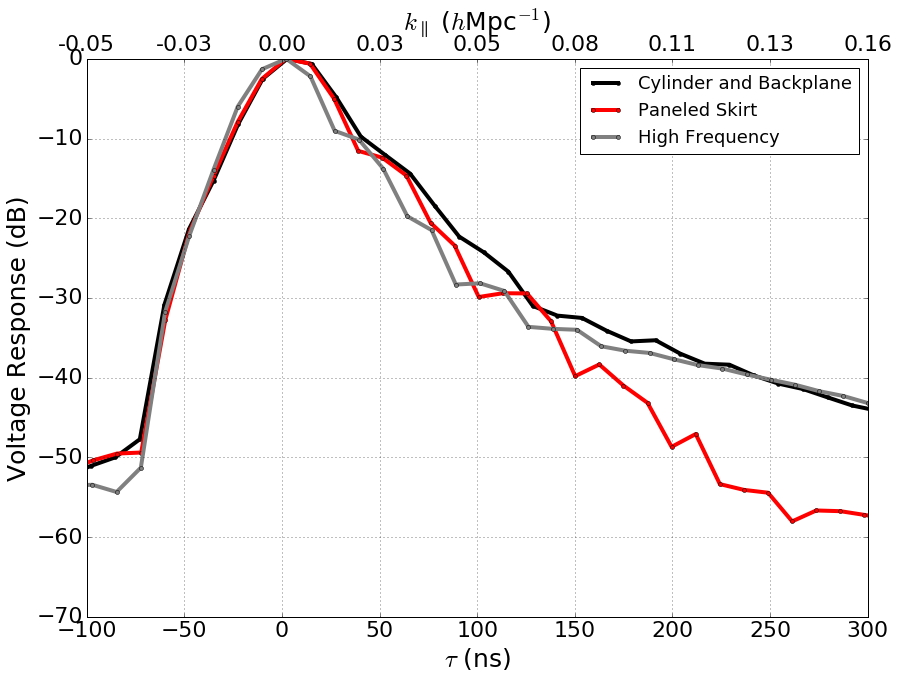

In [97]:
flow=[50]
fhigh=[130]
plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')


#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['r'],xlims=[-100,400])
#plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


flow=[100]
fhigh=[180]
plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
#plotTraces(traceListFeedOnlyCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedOnlyCylinderBackPlaneHighFreq[1],lastPlot=True,translate=0.,labels=['High Frequency\nFeed Only'],colors=['grey'],ls='--',xlims=[-100,300],nLegendCols=3)




p.savefig('../analysis/compare_Traces.pdf')







7698
0.052281339
6586
0.052031081
7726
0.07669872
7868
0.06002463
7712
0.10938557
7974
0.087386109


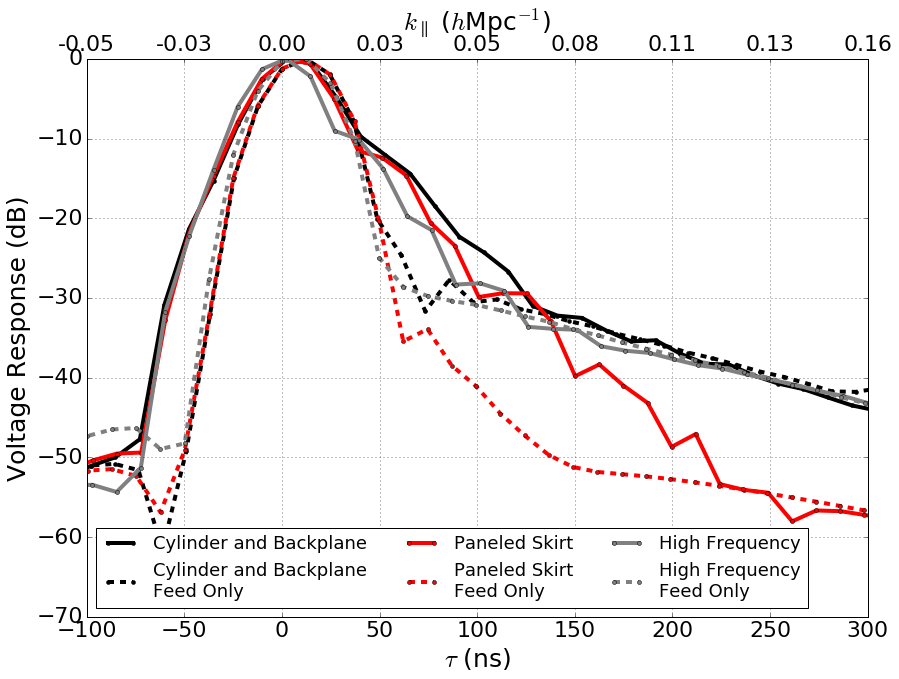

In [98]:
flow=[50]
fhigh=[130]
l0=plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])[0]
plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')


#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
l1=plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['r'],xlims=[-100,400])[0]
plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


flow=[100]
fhigh=[180]
l2=plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=False,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-150,400])[0]
plotTraces(traceListFeedOnlyCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedOnlyCylinderBackPlaneHighFreq[1],lastPlot=True,translate=0.,labels=['High Frequency\nFeed Only'],colors=['grey'],ls='--',xlims=[-150,400],nLegendCols=3)

p.gca().legend((l0,l1,l2),('Cylinder+Backplane','Backplane','Dipole Only'))


p.savefig('../analysis/compare_Traces_withFeeds.pdf')






7698
0.052281339
6586
0.052031081
7726
0.07669872
7868
0.06002463
6688
0.049551547
6142
0.049621958
7712
0.10938557
7974
0.087386109


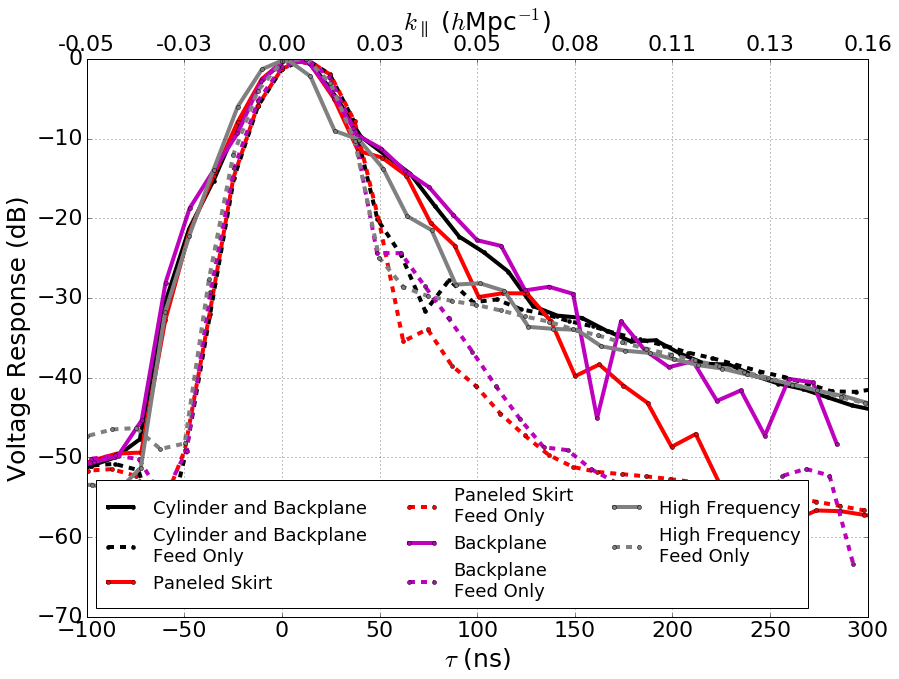

In [99]:
flow=[50]
fhigh=[130]
plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-30,300],ls='--')


#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['r'],xlims=[-100,400])
plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


plotTraces(traceListFeedAndDishBackPlane[0],flow,fhigh,traceListFeedAndDishBackPlane[1],lastPlot=False,translate=35.,labels=['Backplane'],xlims=[-30,300],colors=['m'])
plotTraces(traceListFeedOnlyBackPlane[0],flow,fhigh,traceListFeedOnlyBackPlane[1],lastPlot=False,translate=0.,labels=['Backplane\nFeed Only'],xlims=[-30,300],ls='--',colors=['m'])





flow=[100]
fhigh=[180]
plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=False,translate=35.,labels=['High Frequency'],colors=['grey'],ls='-',xlims=[-100,300])
plotTraces(traceListFeedOnlyCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedOnlyCylinderBackPlaneHighFreq[1],lastPlot=True,translate=0.,labels=['High Frequency\nFeed Only'],colors=['grey'],ls='--',xlims=[-100,300],nLegendCols=3)




#p.savefig('../analysis/compare_Traces_deconstruct_withFeeds.pdf')







7698
0.052281339
6586
0.052031081
6688
0.049551547
6142
0.049621958
4732
0.049648296
6460
0.023882817


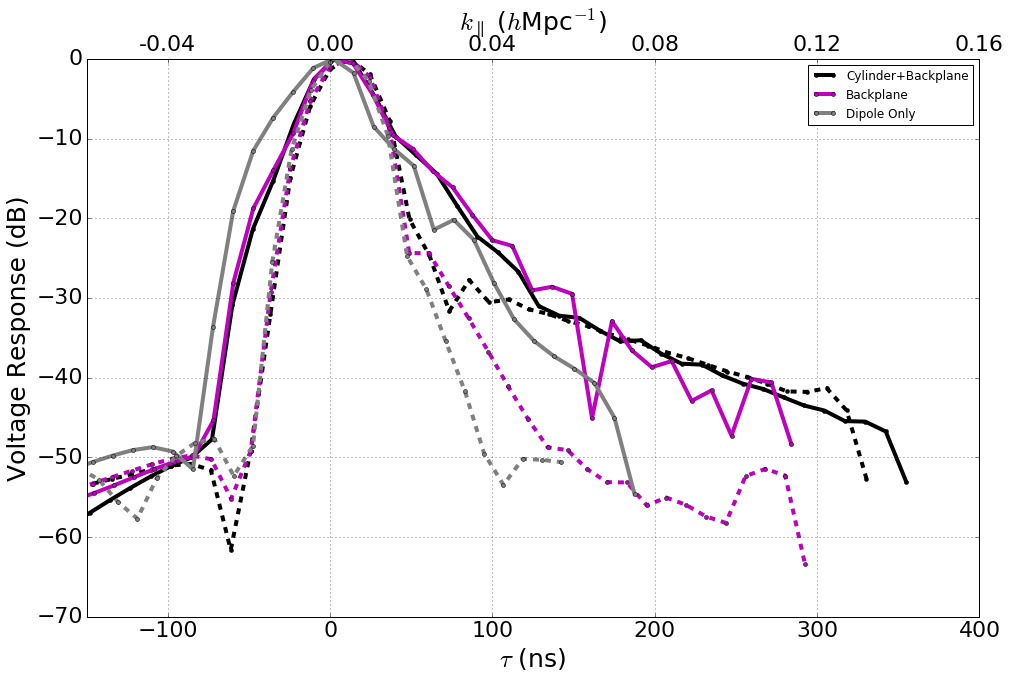

In [10]:
flow=[50]
fhigh=[130]
l0=plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-150,400])[0]
plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=0.,labels=['Cylinder and Backplane\nFeed Only'],xlims=[-150,400],ls='--')


#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#l1=plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['r'],xlims=[-100,400])[0]
#plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=0.,labels=['Paneled Skirt\nFeed Only'],colors=['r'],xlims=[-100,400],ls='--')


l1=plotTraces(traceListFeedAndDishBackPlane[0],flow,fhigh,traceListFeedAndDishBackPlane[1],lastPlot=False,translate=35.,labels=['Backplane'],xlims=[-150,400],colors=['m'])[0]
plotTraces(traceListFeedOnlyBackPlane[0],flow,fhigh,traceListFeedOnlyBackPlane[1],lastPlot=False,translate=0.,labels=['Backplane\nFeed Only'],xlims=[-150,400],ls='--',colors=['m'])


l2=plotTraces(traceListFeedAndDishBareDipole[0],flow,fhigh,traceListFeedAndDishBareDipole[1],lastPlot=False,translate=35.,labels=['Bare Dipole'],xlims=[-150,400],colors=['grey'])[0]
plotTraces(traceListFeedOnlyBareDipole[0],flow,fhigh,traceListFeedOnlyBareDipole[1],lastPlot=True,translate=0.,labels=['Bare Dipole\nFeed Only'],xlims=[-150,400],ls='--',colors=['grey'],nLegendCols=4)

p.gca().legend((l0,l1,l2),('Cylinder+Backplane','Backplane','Dipole Only'))



p.gcf().set_size_inches(16,10)

p.savefig('../analysis/compare_Traces_deconstruct_withFeeds.pdf')








7698
0.052281339
6688
0.049551547
4732
0.049648296
7726
0.07669872
7712
0.10938557


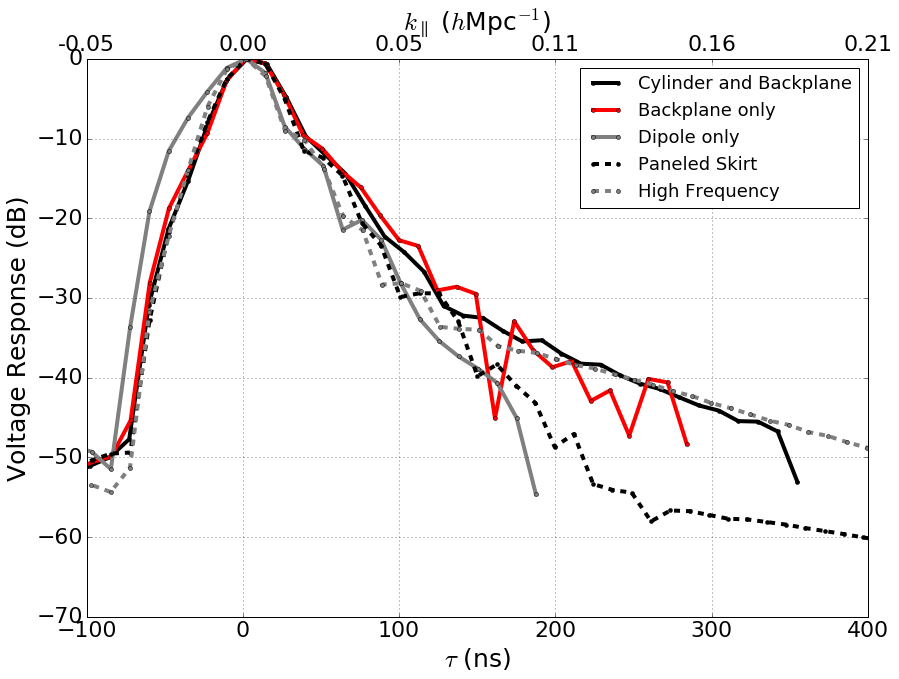

In [100]:
flow=[50]
fhigh=[130]
plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
plotTraces(traceListFeedAndDishBackPlane[0],flow,fhigh,traceListFeedAndDishBackPlane[1],lastPlot=False,translate=35.,labels=['Backplane only'],colors=['red'],xlims=[-100,400])
plotTraces(traceListFeedAndDishBareDipole[0],flow,fhigh,traceListFeedAndDishBareDipole[1],lastPlot=False,translate=35.,labels=['Dipole only'],colors=['grey'],xlims=[-100,400])
plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['k'],xlims=[-100,400],ls='--')
flow=[100]
fhigh=[180]
plotTraces(traceListFeedAndDishCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedAndDishCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],xlims=[-100,400],ls='--')



p.savefig('../analysis/compare_Traces_deconstruct.pdf')





6586
0.052031081
6142
0.049621958
6460
0.023882817
7868
0.06002463
7974
0.087386109


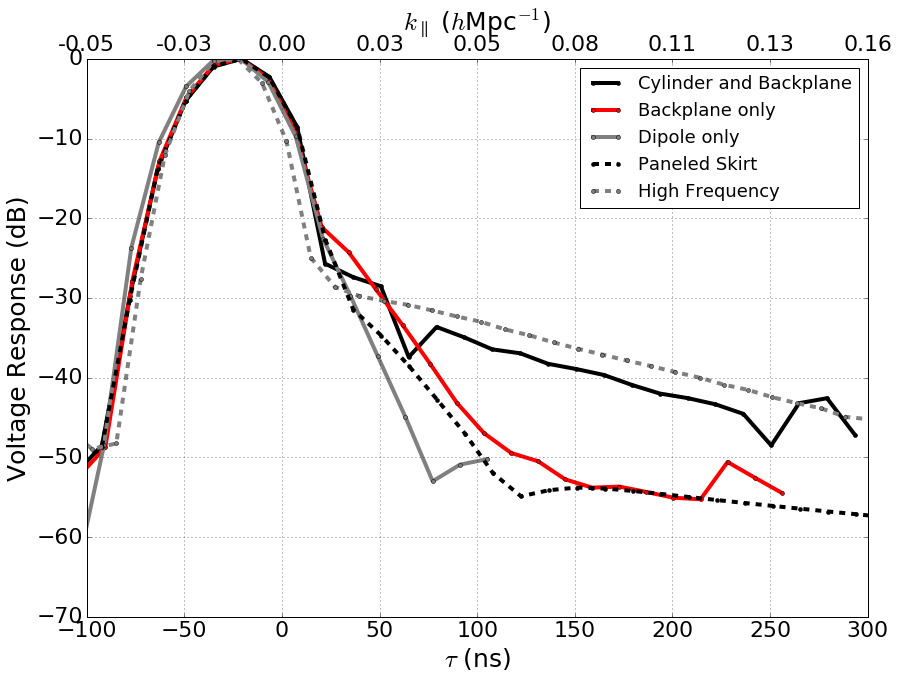

In [101]:
flow=[50]
fhigh=[120]
plotTraces(traceListFeedOnlyCylinderBackPlane[0],flow,fhigh,traceListFeedOnlyCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
plotTraces(traceListFeedOnlyBackPlane[0],flow,fhigh,traceListFeedOnlyBackPlane[1],lastPlot=False,translate=35.,labels=['Backplane only'],colors=['red'],xlims=[-100,400])
plotTraces(traceListFeedOnlyBareDipole[0],flow,fhigh,traceListFeedOnlyBareDipole[1],lastPlot=False,translate=35.,labels=['Dipole only'],colors=['grey'],xlims=[-100,400])
plotTraces(traceListFeedOnlyPaneledDipole[0],flow,fhigh,traceListFeedOnlyPaneledDipole[1],lastPlot=False,translate=35.,labels=['Paneled Skirt'],colors=['k'],xlims=[-100,400],ls='--')
flow=[100]
fhigh=[180]
plotTraces(traceListFeedOnlyCylinderBackPlaneHighFreq[0],flow,fhigh,traceListFeedOnlyCylinderBackPlaneHighFreq[1],lastPlot=True,translate=35.,labels=['High Frequency'],colors=['grey'],ls='--',xlims=[-100,300])



p.savefig('../analysis/compare_Traces_feedOnly.pdf')






7920
0.17953958
114
7698
0.052281339
32
6688
0.049551547
26
7726
0.07669872
48


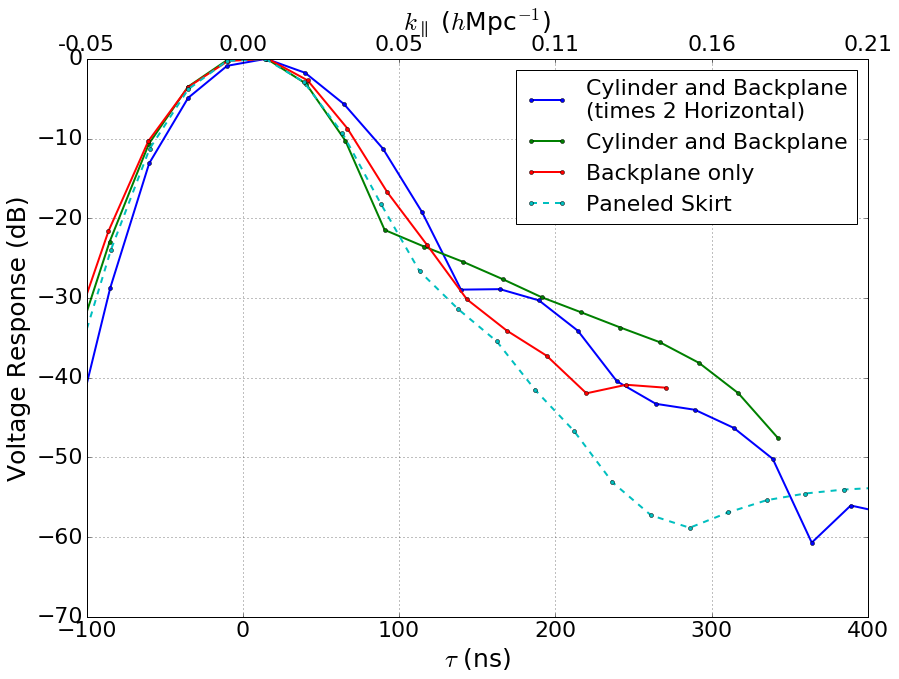

In [18]:
flow=[80]
fhigh=[120]
plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane\n(times 2 Horizontal)'],xlims=[-30,300],colors=['grey'])
plotTraces(traceListFeedAndDishCylinderBackPlaneV2[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
plotTraces(traceListFeedAndDishBackPlaneV2[0],flow,fhigh,traceListFeedAndDishBackPlane[1],lastPlot=False,translate=35.,labels=['Backplane only'],colors=['red'],xlims=[-100,400])
#plotTraces(traceListFeedAndDishBareDipole[0],flow,fhigh,traceListFeedAndDishBareDipole[1],lastPlot=False,translate=35.,labels=['Dipole only'],colors=['grey'],xlims=[-100,400])
plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=True,translate=35.,labels=['Paneled Skirt'],colors=['k'],xlims=[-100,400],ls='--')


#p.savefig('../compare_Traces_v2.pdf')







7920
0.17953958
284
7698
0.052281339
80
6688
0.049551547
66
7726
0.07669872
118


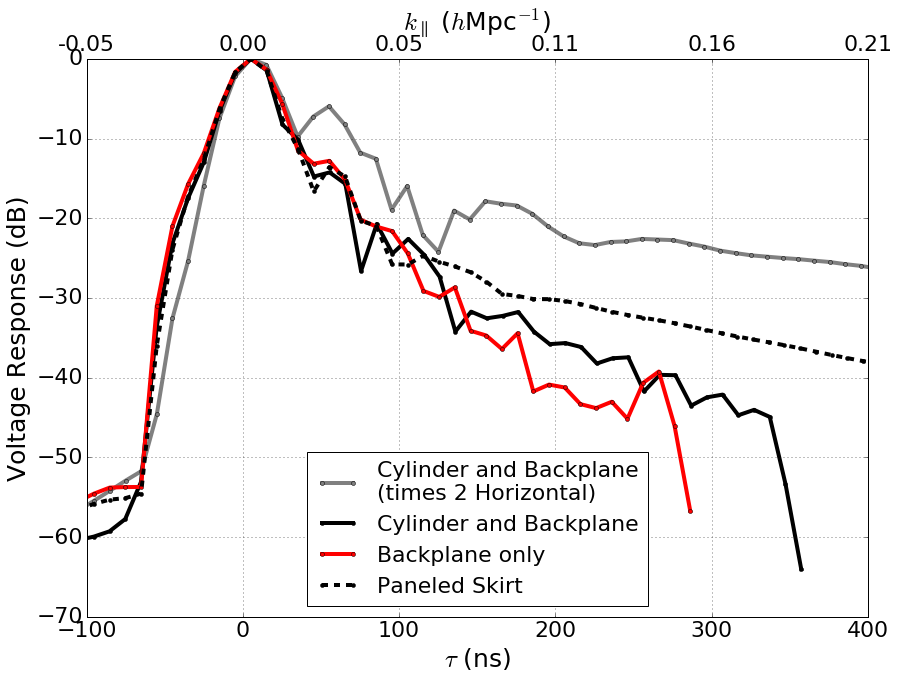

In [17]:
flow=[50]
fhigh=[150]
plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane\n(times 2 Horizontal)'],xlims=[-30,300],colors=['grey'])
plotTraces(traceListFeedAndDishCylinderBackPlaneV2[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
#flow=[50]
#fhigh=[150]
#plotTraces(traceListFeedAndDishCylinderBackPlane[0],flow,fhigh,traceListFeedAndDishCylinderBackPlane[1],lastPlot=False,translate=35.,labels=['Cylinder and Backplane'],xlims=[-30,300])
plotTraces(traceListFeedAndDishBackPlaneV2[0],flow,fhigh,traceListFeedAndDishBackPlane[1],lastPlot=False,translate=35.,labels=['Backplane only'],colors=['red'],xlims=[-100,400])
#plotTraces(traceListFeedAndDishBareDipole[0],flow,fhigh,traceListFeedAndDishBareDipole[1],lastPlot=False,translate=35.,labels=['Dipole only'],colors=['grey'],xlims=[-100,400])
plotTraces(traceListFeedAndDishPaneledDipole[0],flow,fhigh,traceListFeedAndDishPaneledDipole[1],lastPlot=True,translate=35.,labels=['Paneled Skirt'],colors=['k'],xlims=[-100,400],ls='--')


#p.savefig('../compare_Traces_v2.pdf')





